In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy import sparse

# Generate some indices
Even the sparse matrices won't fit in memory. So we will have to loop through them when making predictions or sampling random items.

In [2]:
#count number of items:
indptr = [0]

for chunkID in range(12):
    scores = np.load(f'../processed_data/D4_all{chunkID}.npy')
    indptr.append(indptr[-1] + scores.shape[0])


In [3]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(12)])

# functions to handle the slabs

In [4]:
def extractFPs(chunkID, indptr, isTrain):
    fp = sparse.load_npz(f'../processed_data/D4_all{chunkID}.npz')
    mask = isTrain[indptr[chunkID]:indptr[chunkID+1]]
    return fp[mask]

def buildTrain(indptr, isTrain, verbose=0):
    if verbose:
        print('building training matrix')
    fps = sparse.vstack([extractFPs(i, indptr, isTrain) for i in range(12)])
    return fps

def chunkPredictProba(model, indptr, isTrain, verbose=0):
    if verbose:
        print('predicting probabilities')
    probas = []
    for chunkID in range(12):
        fps = extractFPs(chunkID, indptr, ~isTrain)
        proba = model.predict_proba(fps)[:,1]
        probas.append(proba)
    return np.concatenate(probas)

# Train and RF regressor and Logistic Regression models

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000, C=1)

# How long to find the 50k - 500k top 0.4%?

In [18]:
trainingSetSizes = [5000, 10_000] + [10000*2<<i for i in range(0,8)]
desiredNumLigands = [50_000, 100_000, 150_000, 200_000,]

In [19]:
#this is the _actual_ observed cutoff at 0.3th percentile.
test_cutoff = np.percentile(scores, 0.3)
#mask identifying the top hits.
topK = scores<test_cutoff


#df = pd.DataFrame(columns=['Algorithm', 'Training size', 'Fraction', 'N hits wanted', 'N hits explored'])
df = pd.DataFrame(columns=['Algorithm', 'Training size', 'N hits wanted', 'N hits explored'])
count=0

for i in range(3):
    #for percent in np.array([0.1, 0.25, 0.5, 0.75, 0.9]):
    for numWanted in desiredNumLigands:

        idx = np.arange(scores.shape[0])
        np.random.shuffle(idx)

        for size in trainingSetSizes:
            #numWanted = int(percent * scores.shape[0] * 0.003)
            #print('numWanted:', numWanted, 'percent:', percent)
            #split indices into train and test:
            train = idx[:size].copy()
            test = idx[size:].copy()
            train.sort()
            test.sort()
    
            #generate a 'is a training instance' mask. 
            isTrain = np.zeros(scores.shape[0]).astype(bool)
            isTrain[train]=True
    
            #topK molecules already found in the training set:
            numFound = topK[train].sum()
            numRequired = numWanted - numFound
            
            #fit model:
            cutoff = np.percentile(scores[isTrain],0.3)
            model.fit(buildTrain(indptr, isTrain, 1), scores[isTrain]<cutoff)

            #predict (slowest step):
            proba = chunkPredictProba(model, indptr, isTrain, 1)
        
            #rank the probabilities
            proba_sorted = (-proba).argsort()
            
            #sorted the unseen instances by probability (highest prob first):
            test = test[proba_sorted]

            #topK molecules already found in the training set:
            numSampled = np.argmax(np.cumsum(topK[test])>numRequired)
            
            #df.loc[count] = ['morgan_feat', size, percent, numWanted, numSampled+size]
            df.loc[count] = ['morgan_feat', size, numWanted, numSampled+size]
            count+=1
            print(count, size, numWanted, numSampled+size)
            df.to_csv('../processed_data/D4_single_'+str(0.3)+'.csv')
            
            
            
            
            

building training matrix
predicting probabilities
1 5000 50000 1828207
building training matrix
predicting probabilities
2 10000 50000 1709895
building training matrix
predicting probabilities
3 20000 50000 1304008
building training matrix
predicting probabilities
4 40000 50000 991396
building training matrix
predicting probabilities
5 80000 50000 735027
building training matrix
predicting probabilities
6 160000 50000 632774
building training matrix
predicting probabilities
7 320000 50000 695824
building training matrix
predicting probabilities
8 640000 50000 933806
building training matrix
predicting probabilities
9 1280000 50000 1512302
building training matrix
predicting probabilities
10 2560000 50000 2751629
building training matrix
predicting probabilities
11 5000 100000 4922599
building training matrix
predicting probabilities
12 10000 100000 3508388
building training matrix
predicting probabilities
13 20000 100000 2924061
building training matrix
predicting probabilities
14 4000

111 5000 200000 15568463
building training matrix
predicting probabilities
112 10000 200000 15114089
building training matrix
predicting probabilities
113 20000 200000 11102076
building training matrix
predicting probabilities
114 40000 200000 8429079
building training matrix
predicting probabilities
115 80000 200000 6433748
building training matrix
predicting probabilities
116 160000 200000 5443631
building training matrix
predicting probabilities
117 320000 200000 4685922
building training matrix
predicting probabilities
118 640000 200000 4303896
building training matrix
predicting probabilities
119 1280000 200000 4401979
building training matrix
predicting probabilities
120 2560000 200000 5260605


In [8]:
test_cutoff = np.percentile(scores, 0.3)

topK = scores<test_cutoff

#df = pd.DataFrame(columns=['Algorithm', 'Training size', 'N ligands explored', '% top-k found'])
df = pd.DataFrame(columns=['Algorithm', 'Training size', 'N hits wanted', 'N hits explored'])
count=0

for i in range(3):
    for numWanted in desiredNumLigands:
        idx = np.arange(scores.shape[0])
        np.random.shuffle(idx)

        for size in trainingSetSizes:
            #split indices into train and test:
            train = idx[:size].copy()
            test = idx[size:].copy()
            train.sort()
            test.sort()
    
            #generate a 'is a training instance' mask. 
            isTrain = np.zeros(scores.shape[0]).astype(bool)
            isTrain[train]=True
    
            #topK molecules already found in the training set:
            numFound = topK[train].sum()
            numRequired = numWanted - numFound
            
            #fit model:
            cutoff = np.percentile(scores[isTrain],0.3)
            model.fit(buildTrain(indptr, isTrain, 1), scores[isTrain]<cutoff)

            #predict (slowest step):
            proba = chunkPredictProba(model, indptr, isTrain, 1)
        
            #rank the probabilities
            proba_sorted = (-proba).argsort()
            
            #sorted the unseen instances by probability (highest prob first):
            test = test[proba_sorted]

            #topK molecules already found in the training set:
            numSampled = np.argmax(np.cumsum(topK[test])>numRequired)
            
            df.loc[count] = ['morgan_feat', size, numWanted, numSampled+size]
            count+=1
            print(count, size, numWanted, numSampled+size)
                
                
            df.to_csv('../processed_data/D4_single_'+str(0.3)+'.csv')

building training matrix
predicting probabilities
1 5000 25000 641919
building training matrix
predicting probabilities
2 10000 25000 574374
building training matrix
predicting probabilities
3 20000 25000 360247
building training matrix
predicting probabilities
4 40000 25000 335954
building training matrix
predicting probabilities
5 80000 25000 292909
building training matrix
predicting probabilities
6 160000 25000 313360
building training matrix
predicting probabilities
7 320000 25000 445866
building training matrix
predicting probabilities
8 640000 25000 742314
building training matrix
predicting probabilities
9 1280000 25000 1360981
building training matrix
predicting probabilities
10 2560000 25000 2617533
building training matrix
predicting probabilities
11 5000 50000 1541107
building training matrix
predicting probabilities
12 10000 50000 1630392
building training matrix
predicting probabilities
13 20000 50000 1007539
building training matrix
predicting probabilities
14 40000 5000

KeyboardInterrupt: 

In [20]:
percentiles = np.argsort(np.argsort(scores)) * 100. / (scores.shape[0] - 1)


In [28]:
docking_scores = np.array(df['Energy'].str.strip('¶')).astype(float)

In [35]:
percentiles = np.concatenate([scores, docking_scores]).argsort().argsort()*100 / (scores.shape[0]+docking_scores.shape[0] - 1)




In [43]:
ranks = np.concatenate([scores, docking_scores]).argsort().argsort()

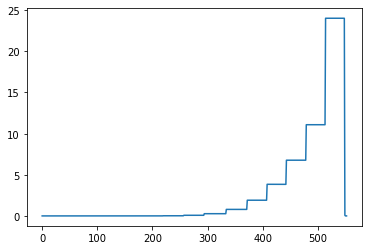

In [39]:
plt.plot(percentiles[-docking_scores.shape[0]:])

In [37]:
3.17815987e+01

31.7815987

In [26]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df.head()

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,Binder or not,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,1,1390.0,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,0,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,0,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,0,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,0,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0


In [41]:
df['percentile'] = percentiles[-docking_scores.shape[0]:]



In [46]:
df['rank'] = ranks[-docking_scores.shape[0]:]+1

In [48]:
len(scores)

116241184

In [47]:
df

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,...,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses,percentile,rank
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,...,1390.00,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0,0.000000,1
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,...,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0,0.000002,3
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,...,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0,0.000003,5
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,...,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0,0.000006,8
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,...,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0,0.000009,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,ZINC000664448457,27921026,345068,-35,0.40,ZINC000000346678,0,1,-35,1,...,NaN,NaN,NaN,NT,6.51,CC1C[C@H]2CC[C@@H](C1)N2C(=O)C(=O)c1ccc(F)cc1,Z2615266005,0.0,24.022647,27924343
549,ZINC000621433144,96169,611,-57.82¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,4.32,>10000,>10000,0.18,ND,CC(C)N1C[C@H](C)[C@@H](NC(=O)N2Cc3ccccc3[C@@H]...,Z3269026405,NaN,0.082698,96131
550,ZINC000361131264,2654,611,-64.61¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,72.00,>10000,>10000,7.31,ND,CC(C)N1C[C@@H](NC(=O)N2Cc3ccccc3[C@@H]2C)[C@H]...,Z3269026402,NaN,0.002405,2797
551,ZINC000361131265,8599,611,-62.63¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,185.00,>10000,>10000,59.1,ND,CC(C)N1C[C@@H](C)[C@@H](NC(=O)N2Cc3ccccc3[C@@H...,Z3269026404,NaN,0.007551,8778


In [49]:
df.to_csv('/home/lewis/Desktop/41586_2019_917_MOESM4_ESM.csv')